# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
!pip install gradio jinja2

In [ ]:
!pip list

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import gradio as gr
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

2024-08-09 17:48:40.973062: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 17:48:41.266646: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 17:48:41.608088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 17:48:41.816654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 17:48:41.880856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 17:48:42.592158: I tensorflow/core/platform/cpu_feature_gu

In [31]:
df_main = pd.read_csv(os.path.join('data','train.csv', 'train.csv'))
df_vi = pd.read_csv(os.path.join('data', 'train.csv','ViCTSD_train.csv'))
df_vi = df_vi.rename(columns={"Unnamed: 0": "id", "Comment": "comment_text", "Toxicity": "toxic"})

In [32]:
common_columns = [col for col in df_vi.columns if col in df_main.columns]

In [33]:
new_df_filtered = df_vi[common_columns]

# Add missing columns to new_df_filtered with default value 0
for column in df_main.columns:
    if column not in new_df_filtered.columns:
        new_df_filtered[column] = 0

/tmp/ipykernel_7203/3909117209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtered[column] = 0
/tmp/ipykernel_7203/3909117209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtered[column] = 0


In [34]:
# Reorder the columns in new_df_filtered to match the order in main_df
new_df_filtered = new_df_filtered[df_main.columns]
new_df_filtered.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6326,Thật tuyệt vời...!!!,0,0,0,0,0,0
1,7835,"mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy...",0,0,0,0,0,0
2,4690,tôi thấy người lái xe hơi bấm còi mới là người...,1,0,0,0,0,0
3,6011,Coi dịch là giặc. Đã mang tên đó mà xâm nhập V...,0,0,0,0,0,0
4,9303,Thương các bé quá! Các con còn quá nhỏ mà đã p...,0,0,0,0,0,0
5,8959,Sevila đoạt cúp sau loạt đá luân lưu nha,0,0,0,0,0,0
6,64,Angelina Jolie có đôi bàn tay nổi gân guốc quá!,0,0,0,0,0,0
7,5526,"""Tôi không biết bà ấy làm thế nào để xử lý gã ...",0,0,0,0,0,0
8,2082,tấm hình này chắc bộ nhớ máy tính chứa được 1 tấm,0,0,0,0,0,0
9,2936,Không trung sẽ không còn yên tĩnh,0,0,0,0,0,0


In [35]:
# Append the filtered and adjusted data to the main dataframe
updated_df = pd.concat([df_main, new_df_filtered], ignore_index=True)

# Save the updated dataframe back to the main CSV file
updated_df.to_csv(os.path.join('data','train.csv', 'train.csv'), index=False)

# 1. Preprocess

In [2]:
df = pd.read_csv(os.path.join('data','train.csv', 'train.csv'))

In [3]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [4]:
MAX_FEATURES = 200000 # number of words in the vocab

In [5]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [6]:
vectorizer.adapt(X.values)

In [7]:
vectorized_text = vectorizer(X.values)

2024-08-09 17:49:57.997381: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2398622400 exceeds 10% of free system memory.


In [8]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [9]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [10]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [11]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train, epochs=1, validation_data=val)

2024-08-09 17:50:13.337841: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2398622400 exceeds 10% of free system memory.


7287/7287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0826

2024-08-09 20:31:47.954897: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2398622400 exceeds 10% of free system memory.


7287/7287 ━━━━━━━━━━━━━━━━━━━━ 10174s 1s/step - loss: 0.0825 - val_loss: 0.0513


In [14]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

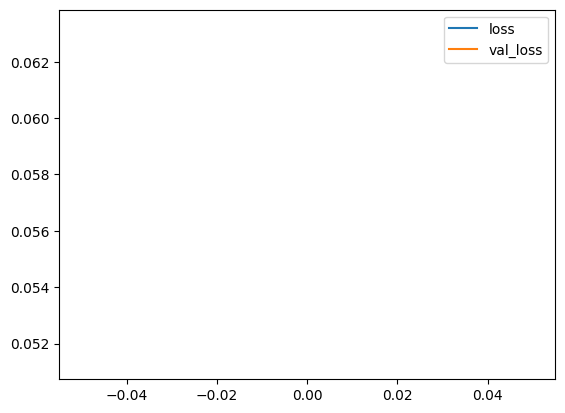

In [15]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [16]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [17]:
res = model.predict(input_text)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 1800), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=int64)
  • training=False
  • mask=None

In [24]:
(res > 0.5).astype(int)

NameError: name 'res' is not defined

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape

# 4. Evaluate Model

In [18]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [19]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

2024-08-09 22:54:50.131514: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2398622400 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-08-09 23:01:15.639884: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8377698063850403, Recall:0.6366867423057556, Accuracy:0.4822286367416382


# 5. Test and Gradio

In [20]:
model.save('vi_toxicity.h5')

In [22]:
model.save('vi_toxicity.keras')



In [23]:
model = tf.keras.models.load_model('vi_toxicity.keras')

/home/lkshpr/Yootek/bad_word_detection/CommentToxicity/EnvCommentToxicity/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
input_str = vectorizer('hey i freaken hate you!')

In [14]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


In [19]:
res

array([[0.7499008 , 0.01961384, 0.24058144, 0.01534711, 0.26574814,
        0.04420615]], dtype=float32)

In [24]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [25]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [26]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://646772139fdfe450a1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
